In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from collections import Counter
from pandas.plotting import scatter_matrix

import xgboost as xgb
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.losses import mae
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.datasets import fetch_california_housing

import warnings
warnings.filterwarnings('ignore')

In [2]:
california_housing = fetch_california_housing(as_frame=True)

In [3]:
california_housing['DESCR']

'.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------------\n\n**Data Set Characteristics:**\n\n:Number of Instances: 20640\n\n:Number of Attributes: 8 numeric, predictive attributes and the target\n\n:Attribute Information:\n    - MedInc        median income in block group\n    - HouseAge      median house age in block group\n    - AveRooms      average number of rooms per household\n    - AveBedrms     average number of bedrooms per household\n    - Population    block group population\n    - AveOccup      average number of household members\n    - Latitude      block group latitude\n    - Longitude     block group longitude\n\n:Missing Attribute Values: None\n\nThis dataset was obtained from the StatLib repository.\nhttps://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html\n\nThe target variable is the median house value for California districts,\nexpressed in hundreds of thousands of dollars ($100,000).\n\nThis dataset was derived from the 1990 U.S

In [4]:
df = california_housing.frame

# EDA & Variable Transforms

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [6]:
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

#### the correlation between features

<Axes: >

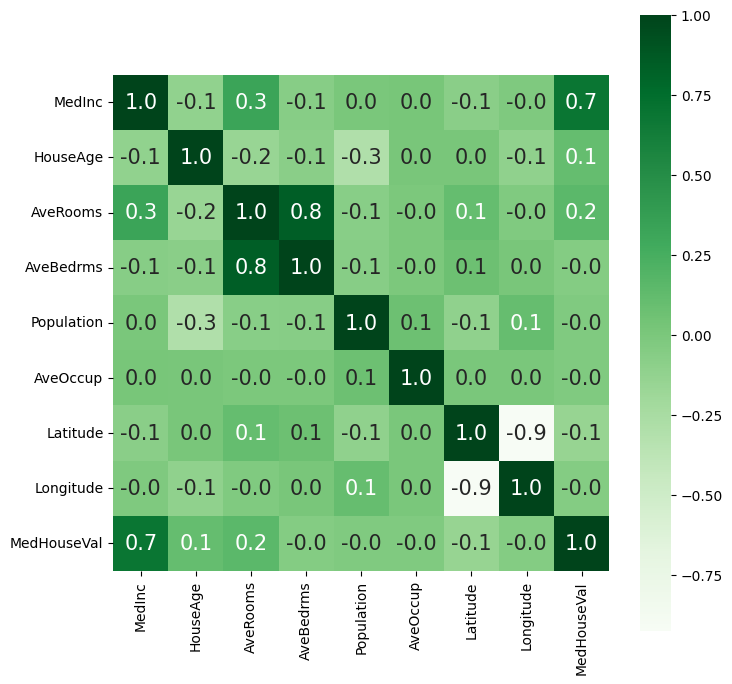

In [7]:
corr = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

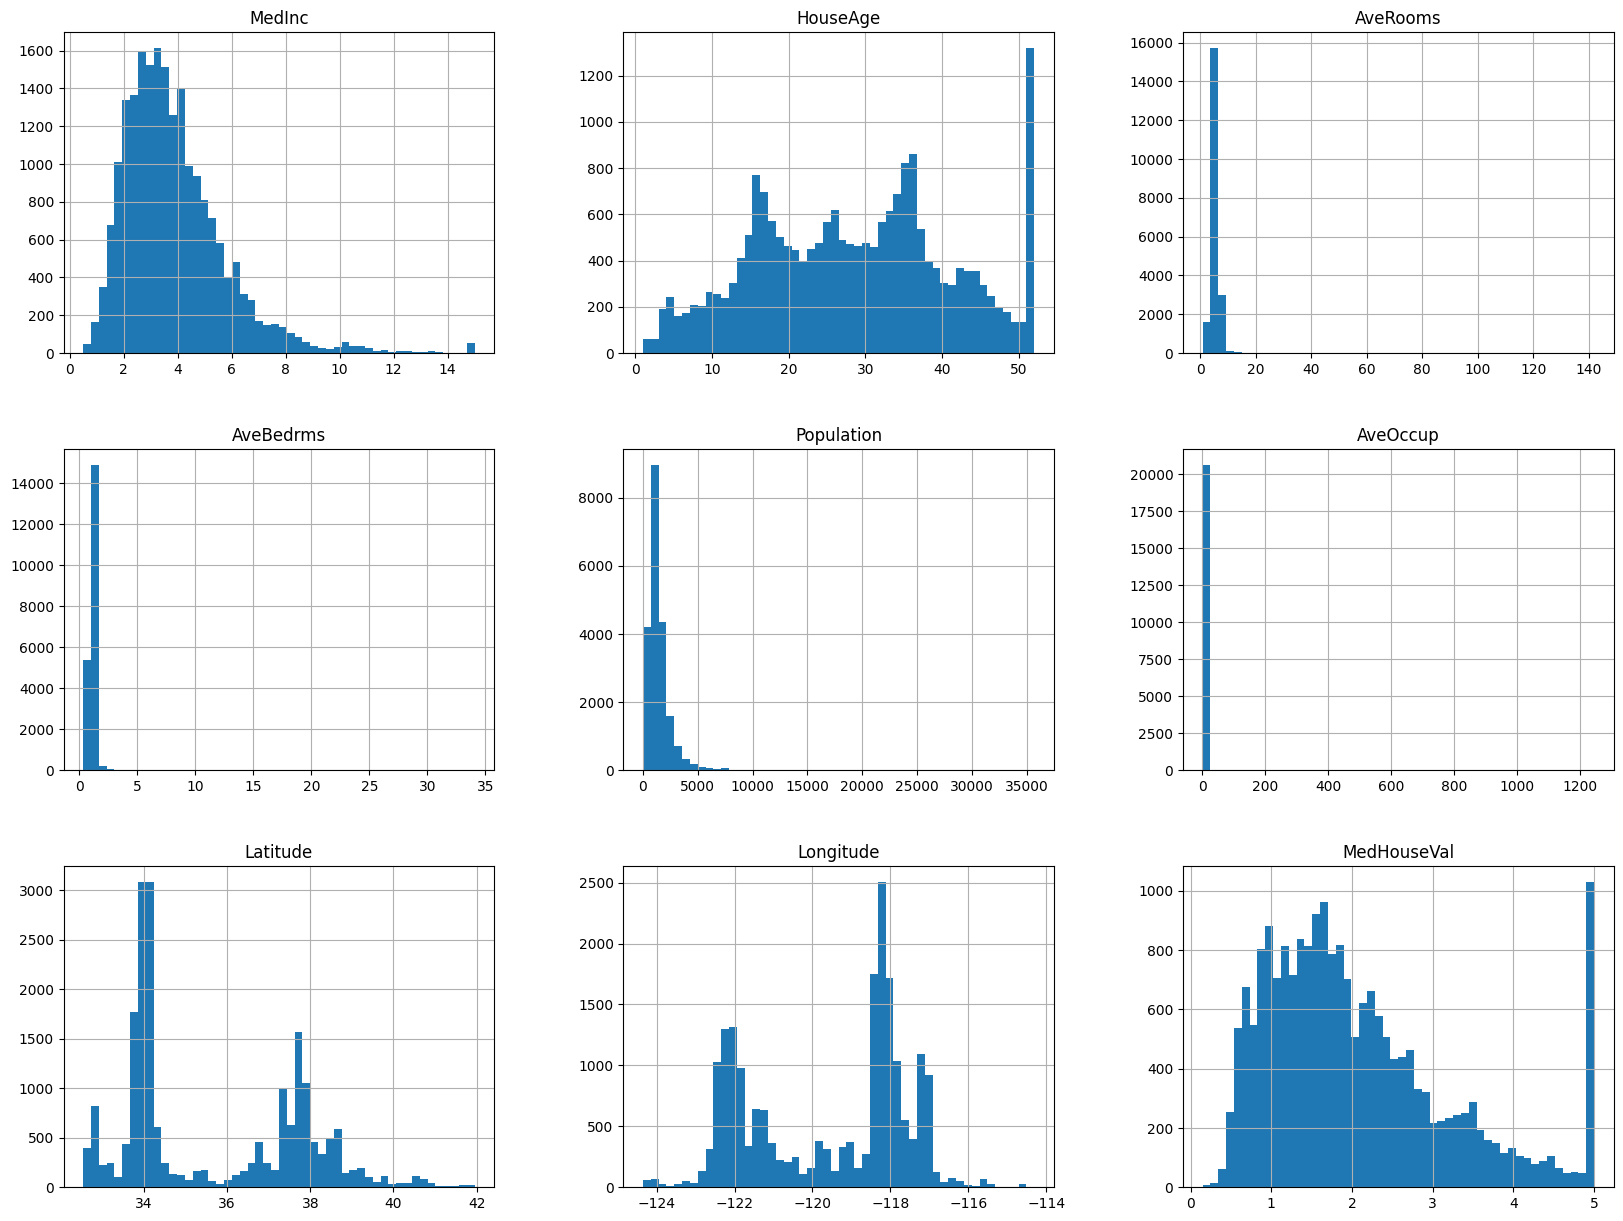

In [8]:
df.hist(figsize=(20,15),bins=50,)
plt.show()

#### some features have obious outliers

## AveRooms

In [9]:
df[df['AveRooms'] > 20]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1024,3.1500,16.0,29.852941,5.323529,202.0,1.980392,38.52,-120.00,1.406
1102,2.4028,17.0,31.777778,9.703704,47.0,1.740741,40.06,-121.54,0.675
1234,4.4063,13.0,28.757282,5.300971,252.0,2.446602,38.26,-120.33,1.558
1238,3.3542,10.0,28.112903,5.604839,298.0,2.403226,38.29,-120.27,1.038
1239,3.0750,13.0,33.989691,6.824742,267.0,2.752577,38.31,-120.27,1.083
...,...,...,...,...,...,...,...,...,...
19736,6.1359,14.0,22.823529,6.352941,35.0,2.058824,40.12,-121.78,1.063
19975,2.1029,11.0,23.994152,5.157895,356.0,2.081871,36.12,-118.54,0.991
19976,3.1250,10.0,21.095238,5.285714,48.0,2.285714,36.19,-118.37,0.713
20093,2.0625,37.0,24.669118,4.897059,338.0,2.485294,38.12,-120.12,0.889


#### number of rooms higher then 20 looks unrealistic, so remove rows with AveRooms higher then 20

In [10]:
df = df[df['AveRooms'] < 20]

In [11]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## AveBedrms

In [12]:
df[df['AveBedrms']>15]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal


## AveOccup

In [13]:
df[df['AveOccup']>15]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1039,4.3029,16.0,6.090592,1.121951,4930.0,17.177700,38.42,-120.97,1.21900
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,0.67500
4479,3.5769,41.0,4.940000,1.100000,925.0,18.500000,34.07,-118.16,1.35700
5986,1.8750,52.0,4.500000,1.206349,2688.0,21.333333,34.10,-117.71,2.12500
7164,2.1845,36.0,4.812155,1.110497,2862.0,15.812155,34.06,-118.17,1.23800
8874,9.3370,52.0,7.285714,1.214286,1154.0,41.214286,34.06,-118.45,5.00001
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,1.54600
12104,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33,1.62500
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,2.25000
13366,4.2578,36.0,5.258824,1.117647,2886.0,33.952941,33.94,-117.63,1.83300


#### number of household members higher then 15 looks unrealistic, so remove them

In [14]:
df = df[df['AveOccup']<15]

In [15]:
def detect_outliers(df, n, features_list):
    outlier_indices = [] 
    for feature in features_list: 
        print(feature)
        Q1 = np.percentile(df[feature], 25)
        Q3 = np.percentile(df[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        print(len(outlier_list_col))
        outlier_indices.extend(outlier_list_col) 
        print('-----')
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) # counts how many features have outliers
    return multiple_outliers

outliers_to_drop = detect_outliers(df, 2, df.columns)

MedInc
675
-----
HouseAge
0
-----
AveRooms
453
-----
AveBedrms
1366
-----
Population
1196
-----
AveOccup
692
-----
Latitude
0
-----
Longitude
0
-----
MedHouseVal
1067
-----


In [16]:
len(outliers_to_drop)

169

In [17]:
print("Before: {} rows".format(len(df)))
df = df.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(df)))

Before: 20552 rows
After: 20383 rows


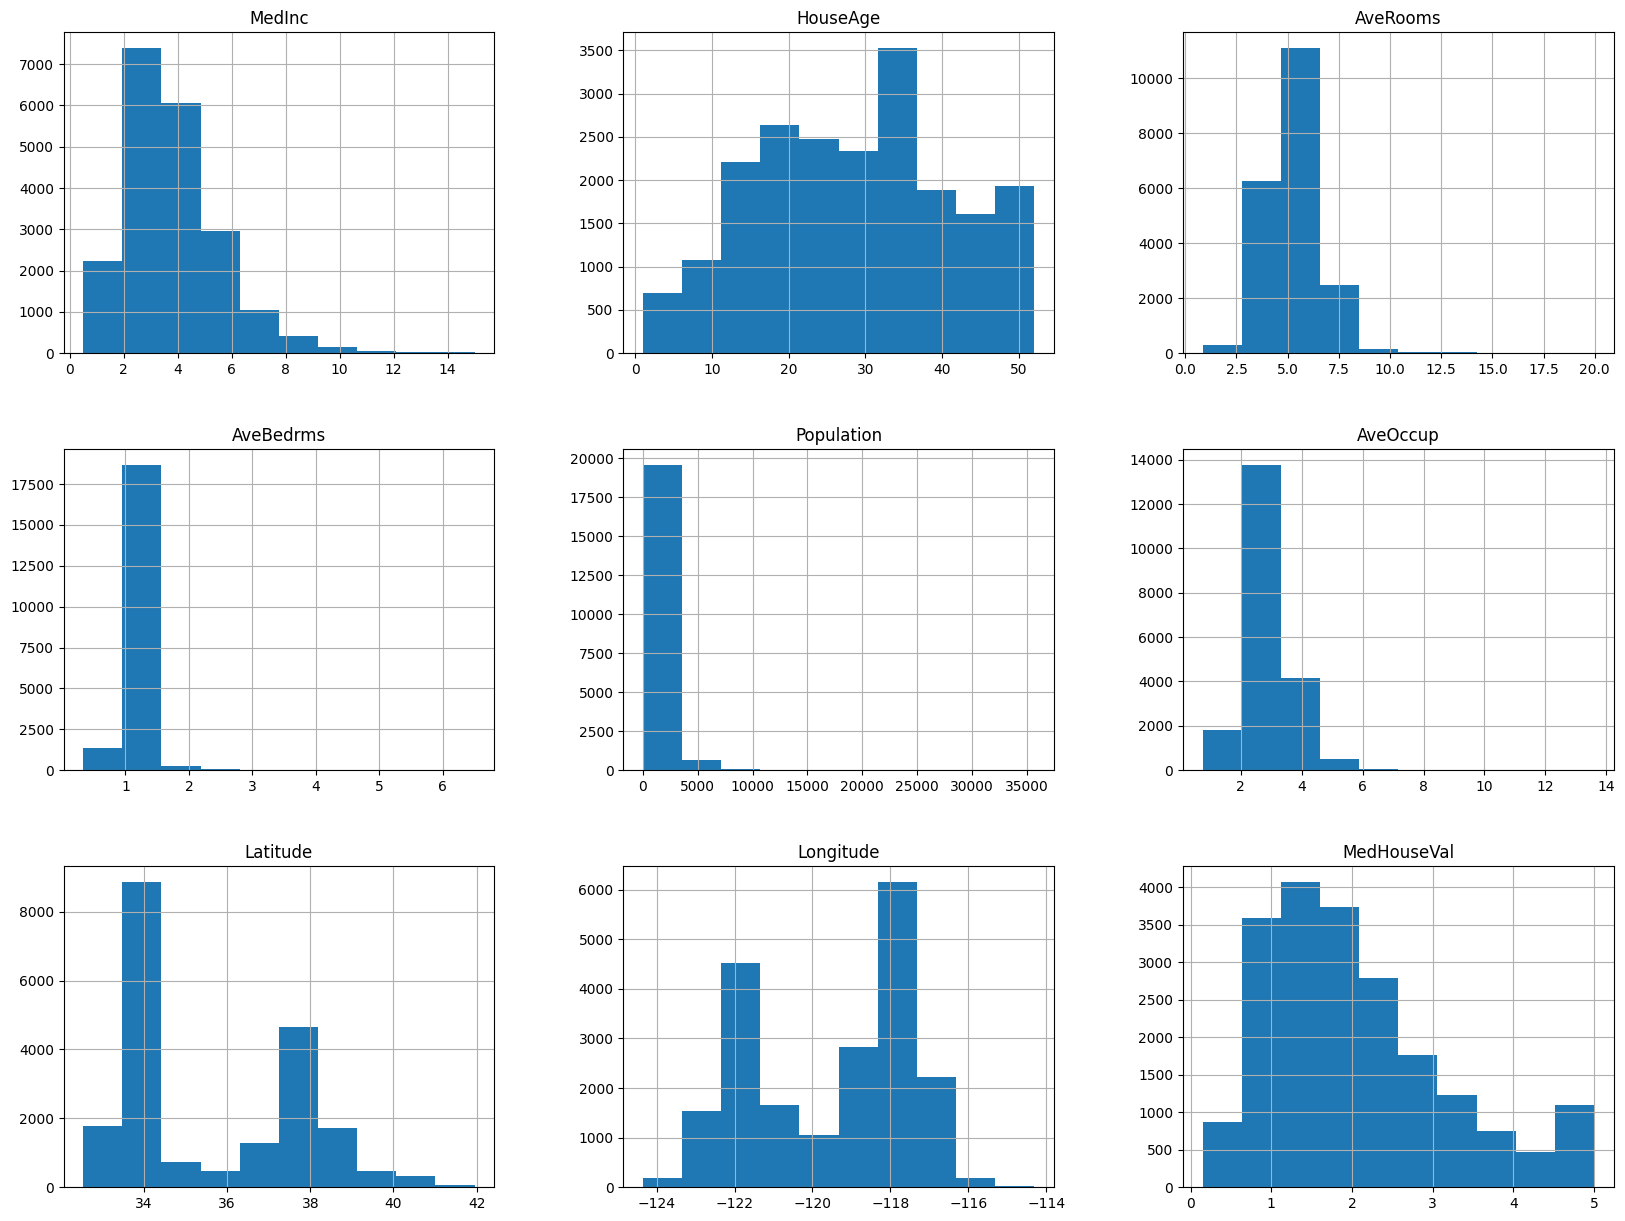

In [18]:
df.hist(figsize=(20,15),bins=10,)
plt.show()

#### build dependency between housing location and price:

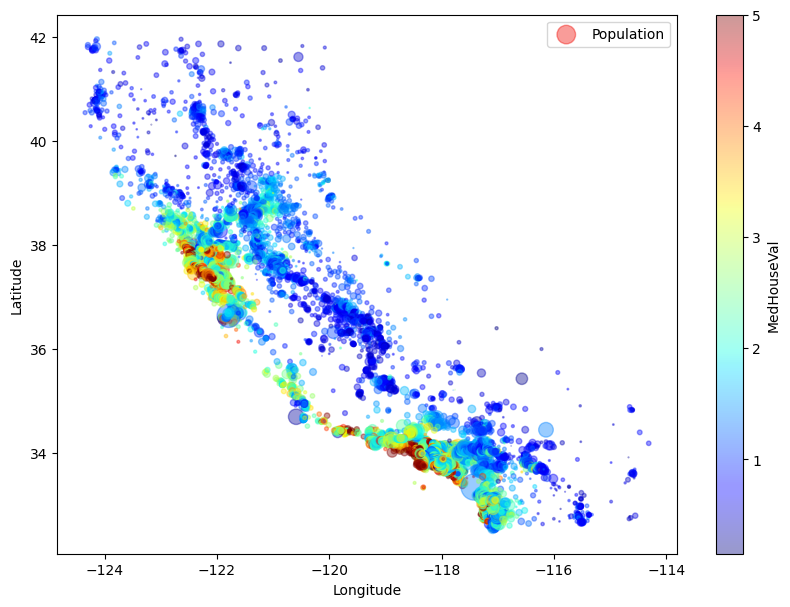

In [19]:
df.plot(kind='scatter',x='Longitude',y='Latitude',alpha=0.4,
            s=df['Population']/100,label="Population",figsize=(10,7),
            c="MedHouseVal",cmap=plt.get_cmap("jet"),colorbar=True,
            sharex=False)
plt.show()

#### more expensive housing are highlighted in red, population size is proportional to the size of the circle
#### and it is clear that the MedHouseVal depends on the location

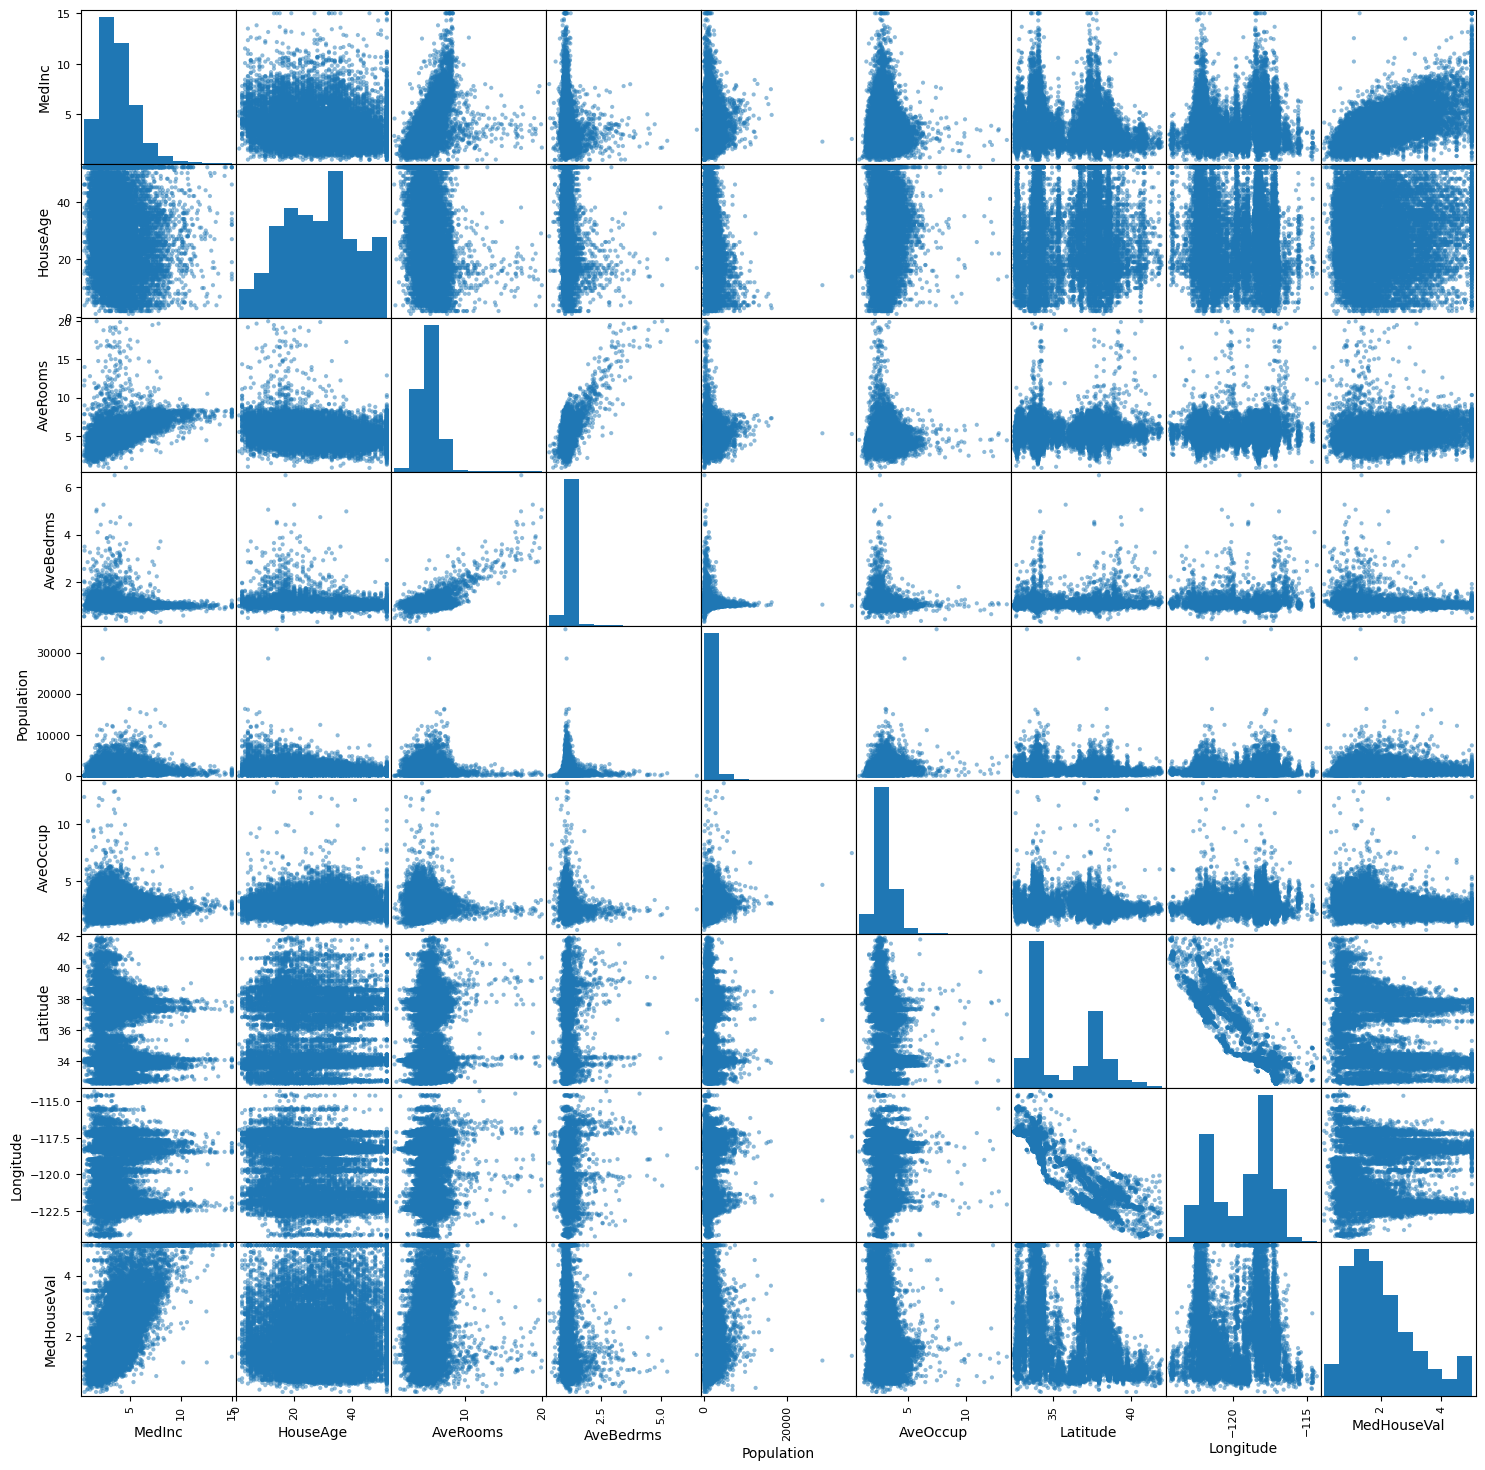

In [20]:
scatter_matrix(df, figsize=(18, 18))
plt.show()

# Target Variable

In [21]:
target = 'MedHouseVal'

<Axes: >

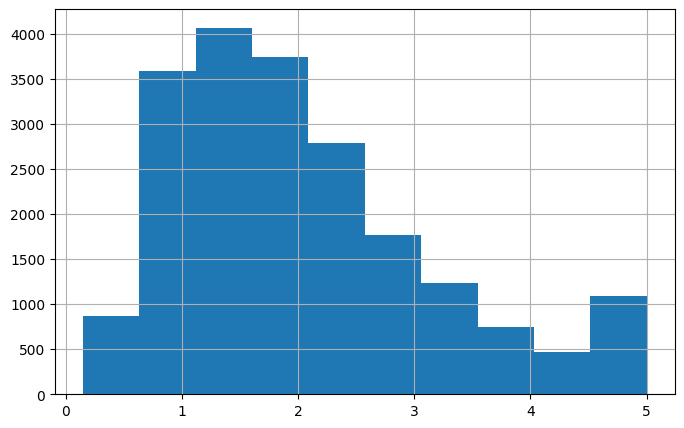

In [22]:
plt.figure(figsize=(8,5))
df.MedHouseVal.hist()

# Data Split

In [23]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20378,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20379,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20380,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20381,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [24]:
features = df.columns.drop(target)
features

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [25]:
X = df[features]
y = df[target]

#### test train split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)

In [27]:
X_train.shape, X_test.shape

((16306, 8), (4077, 8))

In [28]:
def print_metrics(y_test,y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    print(f"MAE {mae}")
    print(f"RMSE {rmse}")
    return mae, rmse

In [29]:
def plot_stats(y_train, y_pred):
    plt.figure(figsize=(8,8))
    plt.scatter(y_train, y_pred, s=10)
    plt.xlabel("Prices")
    plt.ylabel("Predicted prices")
    plt.title("Prices vs Predicted prices")
    plt.show()

In [30]:
def RMSE(y, y_hat):
    return np.sqrt(mean_squared_error(y,y_hat))

## Models builing

In [31]:
metrics = {}

## Random Forest

In [32]:
rfr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=500)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=500, random_state=0)

In [33]:
y_pred = rfr.predict(X_test)

In [34]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['Random Forest'] = metrics_rf

MAE 0.4773328132158765
RMSE 0.6498435564019102


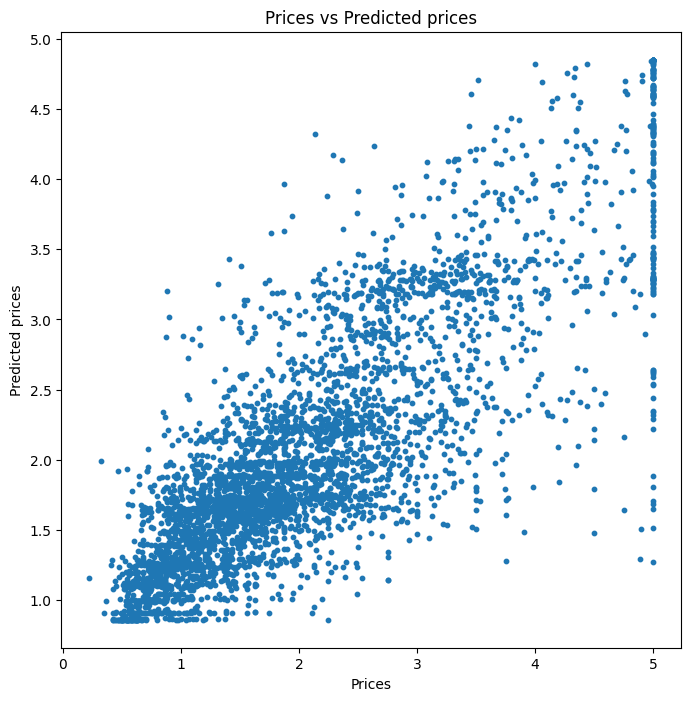

In [35]:
plot_stats(y_test, y_pred)

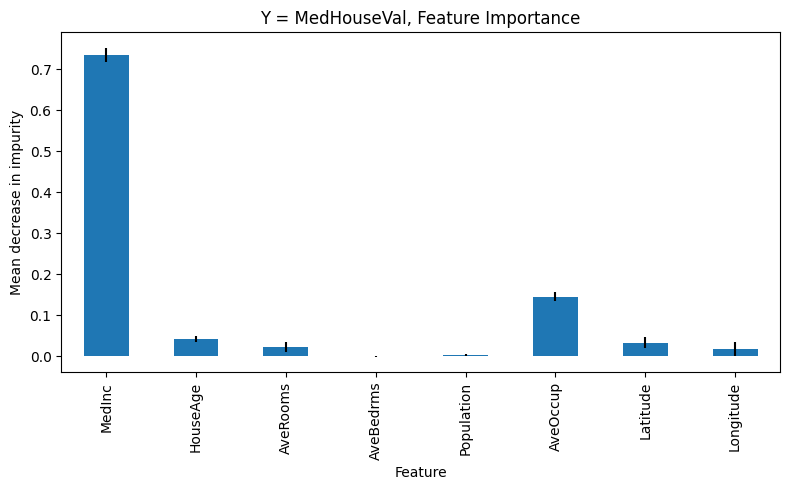

In [36]:
importances = rfr.feature_importances_
feature_names = [f"{i}" for i in X_test.columns]

forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(8,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title(f"Y = MedHouseVal, Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xlabel("Feature")
fig.tight_layout()

## XGBoost

In [37]:
params_xgb = {'n_estimators': 1000, 'random_state':0}

In [38]:
xgb = xgb.XGBRegressor(
        **params_xgb,
        objective='reg:squarederror')

In [39]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [40]:
y_pred = xgb.predict(X_test)

In [41]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['XGB'] = metrics_rf

MAE 0.30877365982257066
RMSE 0.4626908699213053


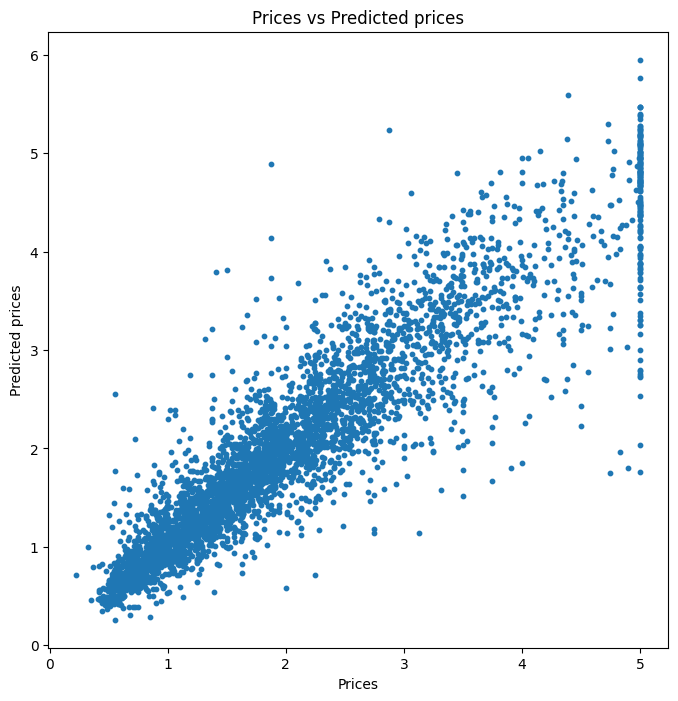

In [42]:
plot_stats(y_test, y_pred)

## Linear Regression

In [43]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression()

In [44]:
y_pred = linear.predict(X_test)

In [45]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['Linear regression'] = metrics_rf

MAE 0.48451485086278123
RMSE 0.6672094012747627


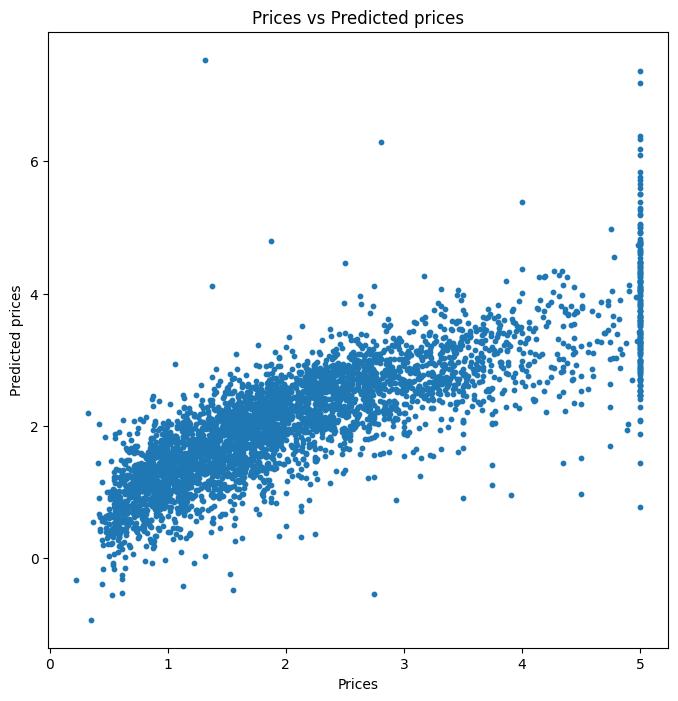

In [46]:
plot_stats(y_test, y_pred)

## LGBM

In [47]:
params_lgb = {
    "n_estimators": 1000,
    "verbose": -1
}

In [48]:
lgbm = LGBMRegressor(**params_lgb)
lgbm.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, verbose=-1)

In [49]:
y_pred = lgbm.predict(X_test)

In [50]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['LGBM'] = metrics_rf

MAE 0.2892695056325222
RMSE 0.44285706466848873


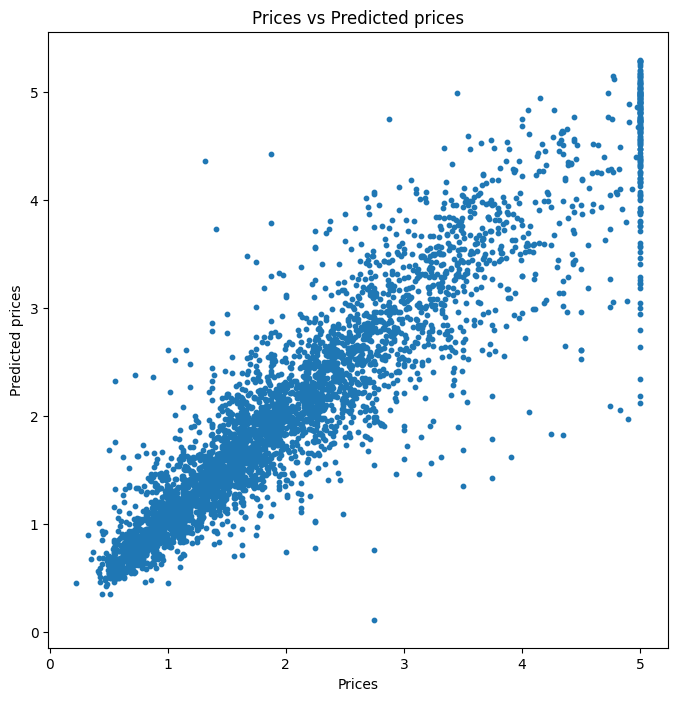

In [51]:
plot_stats(y_test, y_pred)

## Neural Network

In [52]:
X_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
10980,5.1182,17.0,6.002506,1.027569,1224.0,3.067669,33.84,-117.87
16863,4.1776,35.0,4.425172,1.030683,5380.0,3.368817,37.48,-122.19
12746,4.0833,20.0,6.025301,1.000000,2330.0,2.807229,38.64,-121.30
13681,3.0204,8.0,5.469267,1.048463,2739.0,3.237589,34.48,-117.32
10066,4.2850,34.0,5.208469,0.964169,938.0,3.055375,33.87,-117.95


In [53]:
input_dim = X_train.shape[1]

learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
x = Dense(512, activation="tanh")(input_layer)
x = Dense(128, activation="tanh")(x)
x = Dense(16, activation="relu")(x)
ounput_layer = Dense(1, activation="relu")(x)

model = Model(inputs=input_layer, outputs=ounput_layer)

In [54]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,353 (282.63 KB)

 Trainable params: 72,353 (282.63 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=opt)

In [56]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=20,
                    verbose=1,
                    )

Epoch 1/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.3493
Epoch 2/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.0557
Epoch 3/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7173
Epoch 4/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6769
Epoch 5/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6310
Epoch 6/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.5969
Epoch 7/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5640
Epoch 8/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5609
Epoch 9/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5439
Epoch 10/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.5417
Epoch 11/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5159
Epoch 12/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.5205
Epoch 13/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.5195
Epoch 14/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5312
Epoch 15/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - l

In [57]:
y_pred = model.predict(X_test)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [58]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['Neural network'] = metrics_rf

MAE 0.4735591801687301
RMSE 0.6555372569301989


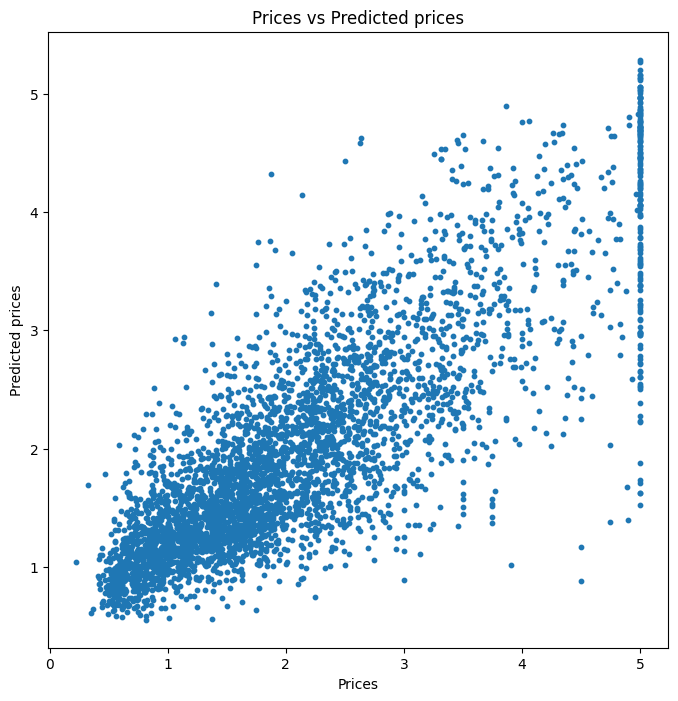

In [59]:
plot_stats(y_test, y_pred)

## CatBoost

In [60]:
cat = CatBoostRegressor(iterations=5000,
                        verbose = 500,
                        eval_metric='RMSE',
                        max_depth = 6,
                        subsample=0.7,
                        learning_rate = 0.04)
cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=1000)

0:	learn: 1.1097480	test: 1.0959589	best: 1.0959589 (0)	total: 173ms	remaining: 14m 26s
500:	learn: 0.4284342	test: 0.4652211	best: 0.4652211 (500)	total: 4.79s	remaining: 43.1s
1000:	learn: 0.3749344	test: 0.4473521	best: 0.4473444 (999)	total: 9.49s	remaining: 37.9s
1500:	learn: 0.3429190	test: 0.4399051	best: 0.4399051 (1500)	total: 13.2s	remaining: 30.9s
2000:	learn: 0.3190878	test: 0.4362682	best: 0.4362637 (1997)	total: 16.5s	remaining: 24.7s
2500:	learn: 0.2990272	test: 0.4332430	best: 0.4332289 (2472)	total: 20.9s	remaining: 20.9s
3000:	learn: 0.2817851	test: 0.4313121	best: 0.4312171 (2982)	total: 25.5s	remaining: 17s
3500:	learn: 0.2676337	test: 0.4300769	best: 0.4299894 (3420)	total: 29.8s	remaining: 12.7s
4000:	learn: 0.2543610	test: 0.4294335	best: 0.4294259 (3998)	total: 34.2s	remaining: 8.53s
4500:	learn: 0.2428179	test: 0.4285060	best: 0.4283675 (4299)	total: 39.4s	remaining: 4.37s
4999:	learn: 0.2323923	test: 0.4278936	best: 0.4278936 (4999)	total: 43.9s	remaining: 0us

In [61]:
y_pred = cat.predict(X_test)

In [62]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['Catboost'] = metrics_rf

MAE 0.27819839231673243
RMSE 0.4278936296211867


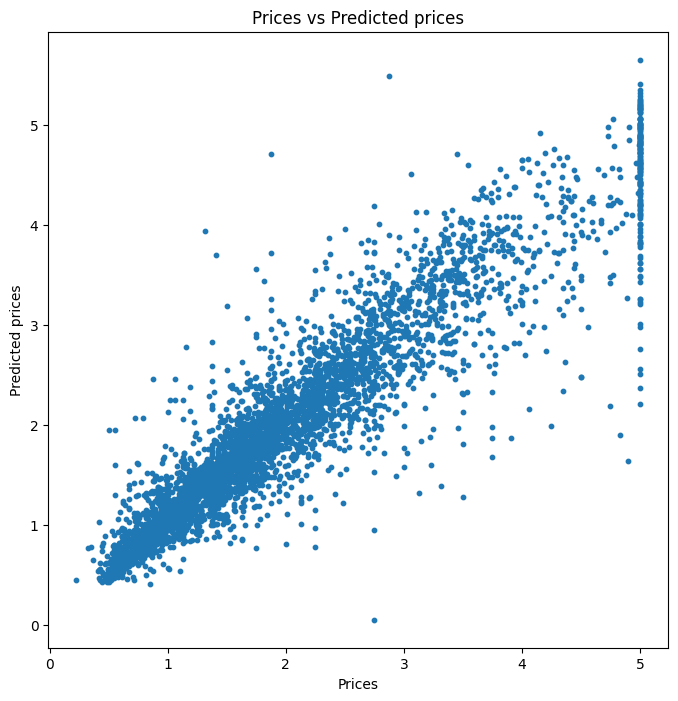

In [63]:
plot_stats(y_test, y_pred)

## Ridge Regression

In [64]:
ridge = Ridge(copy_X=False)
ridge.fit(X_train, y_train)

Ridge(copy_X=False)

In [65]:
y_pred = ridge.predict(X_test)

In [66]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['Ridge'] = metrics_rf

MAE 0.4845084157592911
RMSE 0.6671767540594074


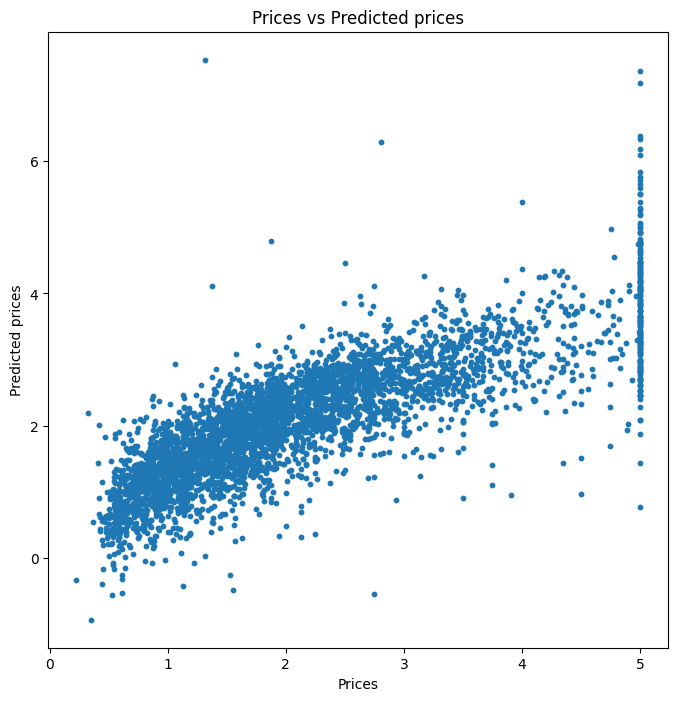

In [67]:
plot_stats(y_test, y_pred)

## BayesianRidge

In [68]:
bay_ridge = BayesianRidge()
bay_ridge.fit(X_train, y_train)

BayesianRidge()

In [69]:
y_pred = bay_ridge.predict(X_test)

In [70]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['BayesianRidge'] = metrics_rf

MAE 36.11243524942121
RMSE 36.11859572705988


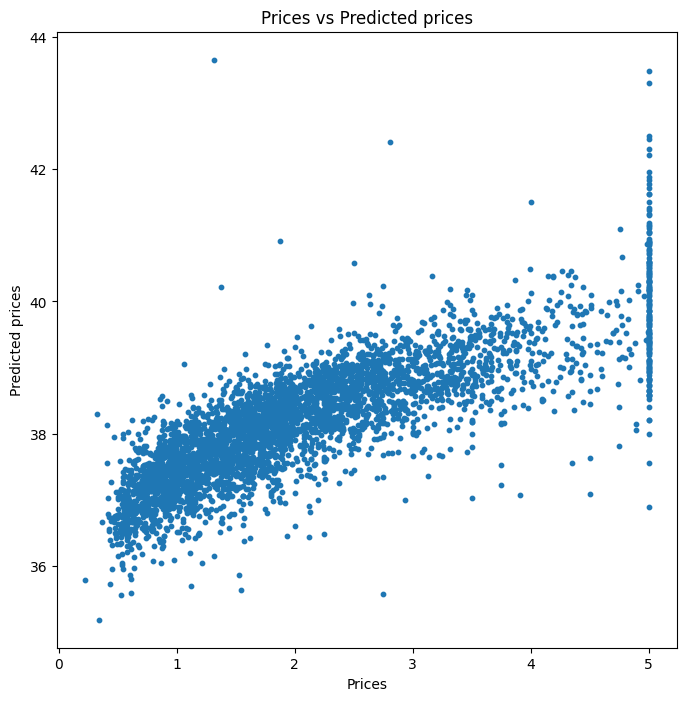

In [71]:
plot_stats(y_test, y_pred)

## SVM

In [72]:
svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X_train, y_train)

SVR(epsilon=0.2)

In [73]:
y_pred = svr.predict(X_test)

In [74]:
metrics_rf = print_metrics(y_test, y_pred)
metrics['SVM'] = metrics_rf

MAE 0.8605983405248501
RMSE 1.1119532780013923


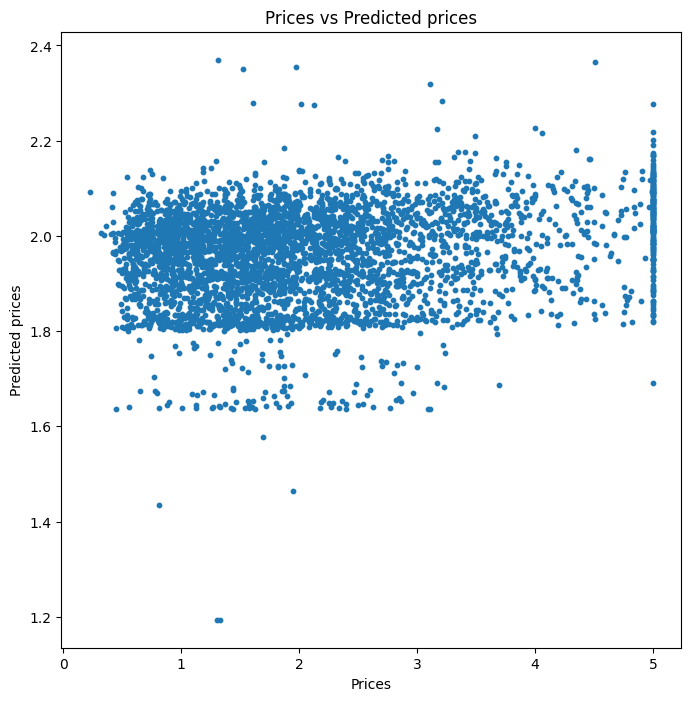

In [75]:
plot_stats(y_test, y_pred)

# Conclusion



In [76]:
table = []
table.append(['S.No.', 'MAE', 'RMSE'])
count = 1
models = ['Random Forest', 'XGB', 'Linear regression', 'LGBM', 'Neural network', 'Catboost', 'Ridge', 'BayesianRidge','SVM']
for model in models:
    row = [count, model, metrics[model][0], metrics[model][1]]
    table.append(row)
    count += 1
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒════╤═══════════════════╤═══════════╤═══════════╕
│    │ S.No.             │       MAE │      RMSE │
╞════╪═══════════════════╪═══════════╪═══════════╡
│  1 │ Random Forest     │  0.477333 │  0.649844 │
├────┼───────────────────┼───────────┼───────────┤
│  2 │ XGB               │  0.308774 │  0.462691 │
├────┼───────────────────┼───────────┼───────────┤
│  3 │ Linear regression │  0.484515 │  0.667209 │
├────┼───────────────────┼───────────┼───────────┤
│  4 │ LGBM              │  0.28927  │  0.442857 │
├────┼───────────────────┼───────────┼───────────┤
│  5 │ Neural network    │  0.473559 │  0.655537 │
├────┼───────────────────┼───────────┼───────────┤
│  6 │ Catboost          │  0.278198 │  0.427894 │
├────┼───────────────────┼───────────┼───────────┤
│  7 │ Ridge             │  0.484508 │  0.667177 │
├────┼───────────────────┼───────────┼───────────┤
│  8 │ BayesianRidge     │ 36.1124   │ 36.1186   │
├────┼───────────────────┼───────────┼───────────┤
│  9 │ SVM               │  0.8

#### The model that recieved the best score is Catboost - 0.27 MAE and 0.43 RMSE